In [1]:
'''
Developed by Boris 

Some comments made by Paula.
date: 08-08-2023

Ocean Hack Week 2023

This script was developed to run a machine learning model to predict SST surface distribution.

'''
# Core libraries for this tutorial
from eosdis_store import EosdisStore # Available via `pip install zarr zarr-eosdis-store`
import xarray as xr

# Other Python libraries
import requests
from pqdm.threads import pqdm
from matplotlib import animation, pyplot as plt
from IPython.core.display import display, HTML

# Python standard library imports
from pprint import pprint

/tmp/ipykernel_256025/303224034.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
data_provider = 'POCLOUD'
mur_short_name = 'MUR-JPL-L4-GLOB-v4.1'

set the region of interest and time

In [14]:
start_time = '2021-09-01T21:00:00Z'
end_time = '2021-09-30T20:59:59Z'
# Bounding box around the Great Lakes

#lats = slice(-5, 35)
#lons = slice(45, 90)

# We reduced the size of matrix to test the model, as we were having issues:
lats = slice(5,20)
lons=slice(50,60)




In [15]:
cmr_url = 'https://cmr.earthdata.nasa.gov/search/granules.json'
response = requests.get(cmr_url,
                        params={
                            'provider': data_provider,
                            'short_name': mur_short_name,
                            'temporal': f'{start_time},{end_time}',
                            'bounding_box': f'{lons.start},{lats.start},{lons.stop},{lats.stop}',
                            'page_size': 2000,
                            }
                       )

In [16]:
granules = response.json()['feed']['entry']


In [17]:
urls = []
for granule in granules:
    for link in granule['links']:
        if link['rel'].endswith('/data#'):
            urls.append(link['href'])
            break

In [18]:
len(urls)

2000

There is only 2000 urls available per request, so I created a txt file, containing the period from 2002 to 2021

In [19]:
with open('urls.txt', 'r') as file:
    # Read the entire content of the file into a string
    file_contents = file.read()
urls = file_contents.split('\n')
urls = urls[0:-2]

You need to create a netrc in your home folder for the authorization process

Change home_folder, login and password 

In [10]:
home_fodler = '/home/'
login = 'login'
password = 'password'

In [ ]:
with open(f"{home_fodler}.netrc", "w") as f:
    f.write("machine urs.earthdata.nasa.gov\n")
    f.write(f"login {login}\n")
    f.write(f"password {password}\n")

In [12]:
import warnings


Let's try to plot the first day

In [21]:
with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        ds = xr.open_zarr(EosdisStore(urls[0]), consolidated=False).sel(lat=lats, lon=lons)


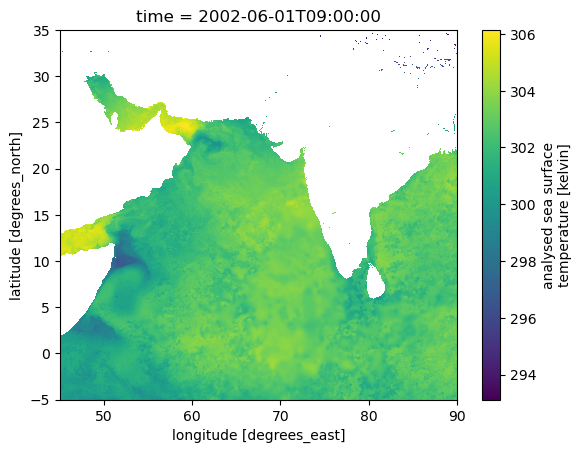

In [22]:
sst = ds.analysed_sst
sst.plot()

In [23]:
def open_as_zarr_xarray(url):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return xr.open_zarr(EosdisStore(url), consolidated=False).sel(lat=lats, lon=lons)

In [ ]:
datasets = pqdm(urls, open_as_zarr_xarray, n_jobs=30)

In [ ]:
ds = xr.concat(datasets, 'time')
ds